In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
import cqm
import sklearn
import scipy
import sklearn.datasets as datasets
import h5py
import os
import pandas as pd
import corner
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
device = torch.device('cuda:0')
from tqdm import tqdm

In [2]:
base = "/nobackup/users/sambt/QR_samples/LHCO/"
f_bb1 = f"{base}/challenge/BB1/merged.h5"
f_ind_bb1 = f"{base}/challenge/BB1/split_indices.h5"
f_rd = f"{base}/rd/RD/merged.h5"
f_ind_rd = f"{base}/rd/RD/split_indices.h5"


fitvars = ['jet1_tau21','jet1_tau32','jet1_tau43']

with h5py.File(f_ind_rd,'r') as f:
    rd_test_idx = f['test_inds'][()]
    rd_train_idx = f['train_inds'][()]
    
with h5py.File(f_ind_bb1,'r') as f:
    bb1_test_idx = f['test_inds'][()]
    bb1_train_idx = f['train_inds'][()]
    
with h5py.File(f_bb1,"r") as fp_b1:
    labels_b1 = np.loadtxt(f"{base}/challenge/BB1/events_LHCO2020_BlackBox1.masterkey")
    b1_test = np.concatenate([fp_b1[v][()][labels_b1==0].reshape(-1,1) for v in fitvars],axis=1)[bb1_test_idx]
    b1_train = np.concatenate([fp_b1[v][()][labels_b1==0].reshape(-1,1) for v in fitvars],axis=1)[bb1_train_idx]
    
with h5py.File(f_rd,"r") as frd:
    label = frd['label'][()]
    mask = label==0
    rd_test = np.concatenate([frd[v][()][mask].reshape(-1,1) for v in fitvars],axis=1)[rd_test_idx]
    rd_train = np.concatenate([frd[v][()][mask].reshape(-1,1) for v in fitvars],axis=1)[rd_train_idx]

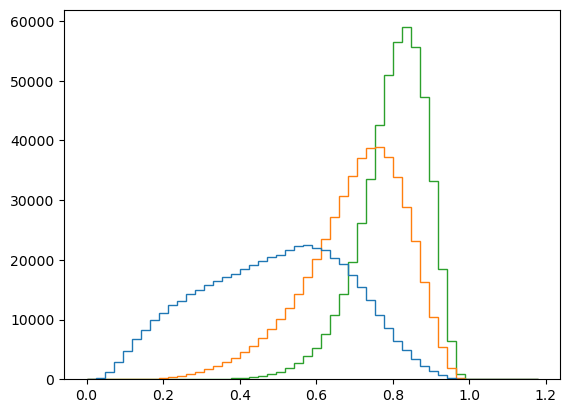

In [15]:
h = plt.hist(rd_train,bins=50,histtype='step')

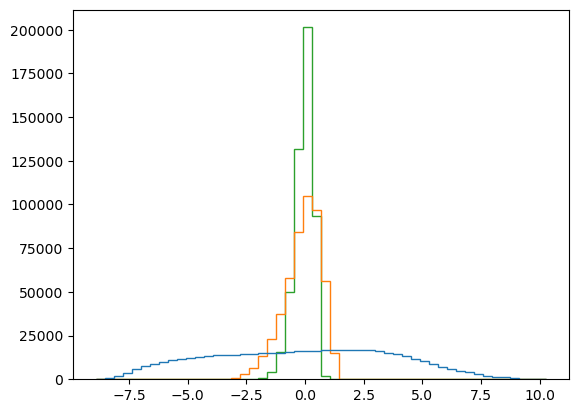

In [30]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler
#scaler = MinMaxScaler(feature_range=(-1,1)).fit(b1_train)
scaler = RobustScaler(quantile_range=(0.01,0.99)).fit(b1_train)
b1_trans = scaler.transform(b1_train)
h = plt.hist(b1_trans,bins=50,histtype='step')
#plt.yscale('log')

In [18]:
b1_trans.mean(axis=0)

array([-0.01973238, -0.11101411, -0.1104914 ])

# Train flows

In [3]:
NF_kwargs = {"flow_type":"NSRATQUAD","tail_bound":3.2,"hidden_features":100,
             "num_layers":1,"num_bins":10,"num_blocks_per_layer":10,"tails":"linear",
            "dropout":0.0,"residual":False}
rangeScale = 3
variables = fitvars
trainer = cqm.chainedNFTrainer("test_LHCO",b1_train,b1_test,rd_train,rd_test,fitvars,control=[],
                                NF_kwargs=NF_kwargs,rangeScale=rangeScale,separateScale=False)

## variable 1

Training flow bkgFlow_step0_jet1_tau21


Loss: 1.556777319908142, p = 83: 100%|██████████| 249/249 [00:42<00:00,  5.93it/s]  


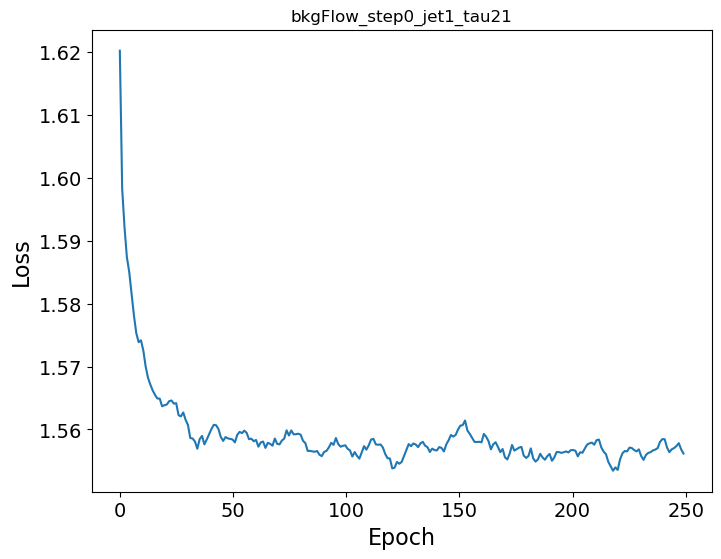

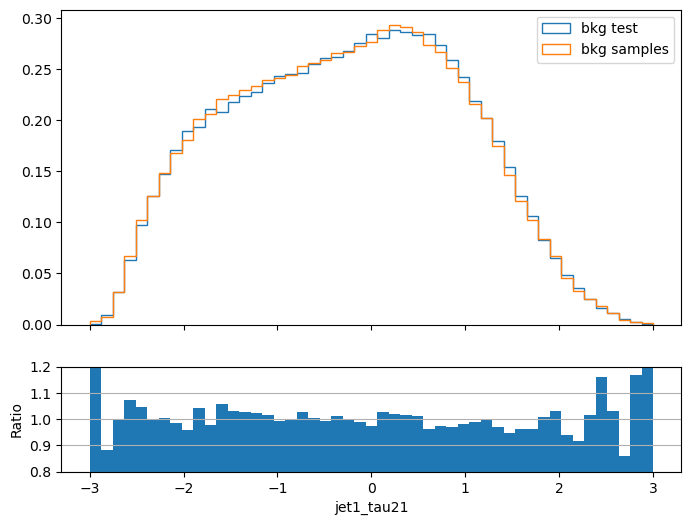

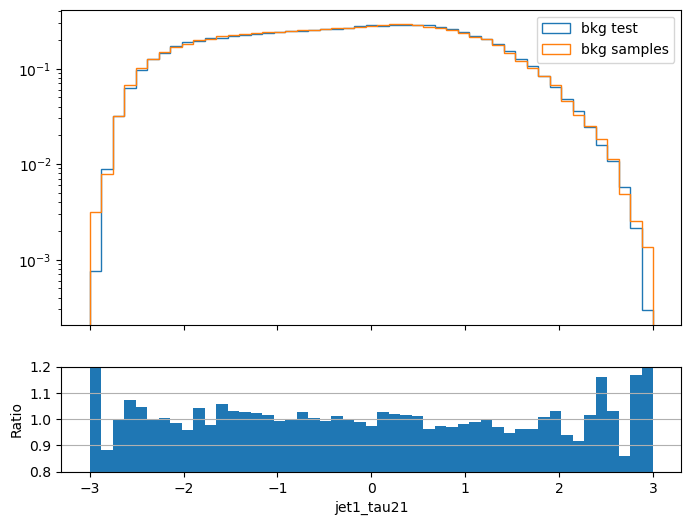

In [4]:
bs = 10000
n_epoch = 5
n_iter = n_epoch*b1_train.shape[0]//bs
trainer.trainCurrentBkg(patience=-1,n_epoch=n_iter,learning_rate=1e-3,bs=bs)
trainer.plotDensity(bkg=True)

Training flow dataFlow_step0_jet1_tau21


Loss: 1.5292671608924866, p = 30: 100%|██████████| 250/250 [00:43<00:00,  5.76it/s] 


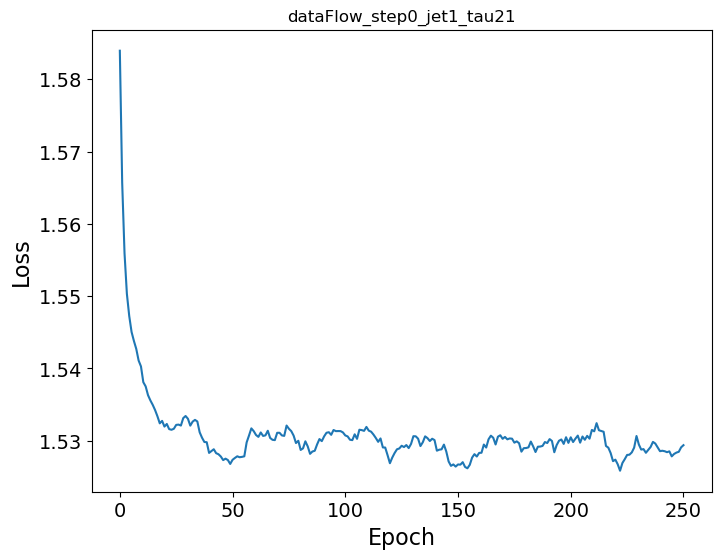

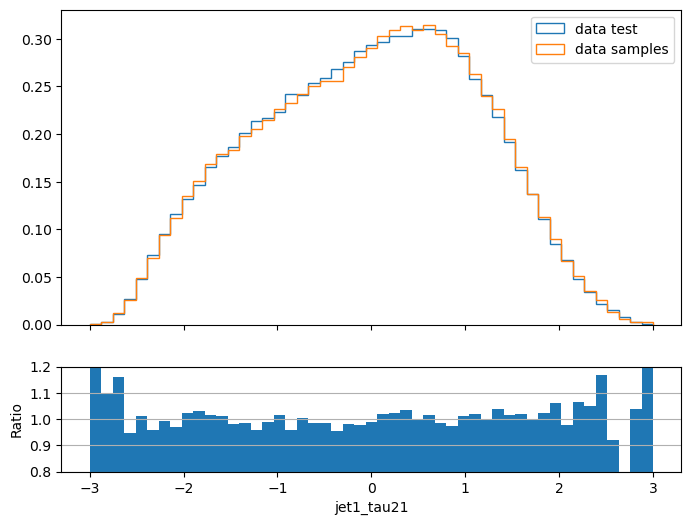

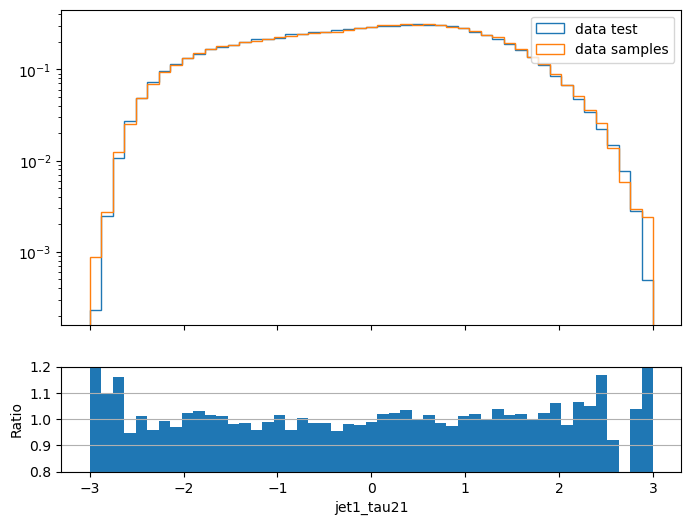

In [5]:
trainer.NF_kwargs = NF_kwargs
bs = 10000
n_epoch = 5
n_iter = n_epoch*rd_train.shape[0]//bs
trainer.trainCurrentData(patience=-1,n_epoch=n_iter,learning_rate=1e-3,bs=bs)
trainer.plotDensity(data=True)

100%|██████████| 25/25 [00:00<00:00, 32.10it/s]


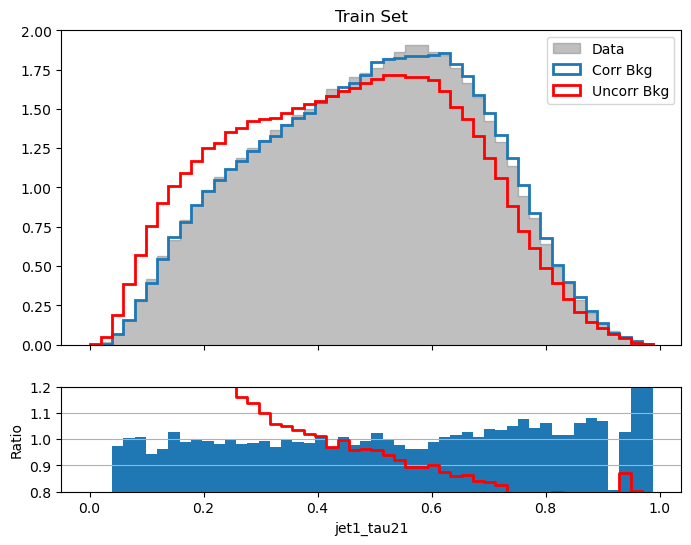

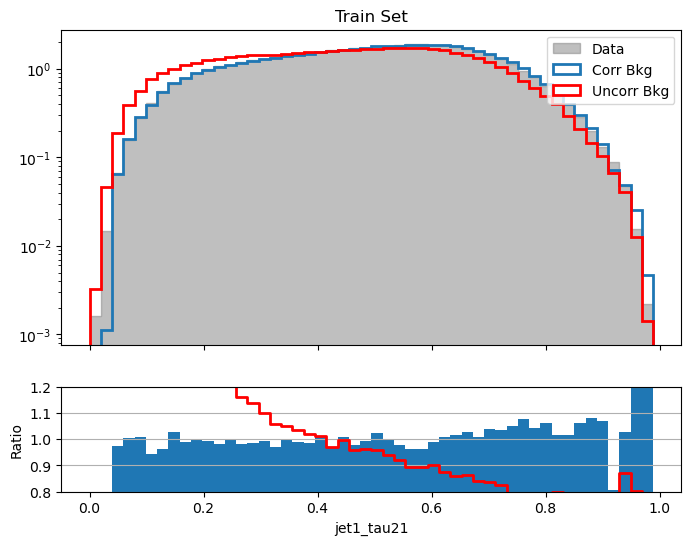

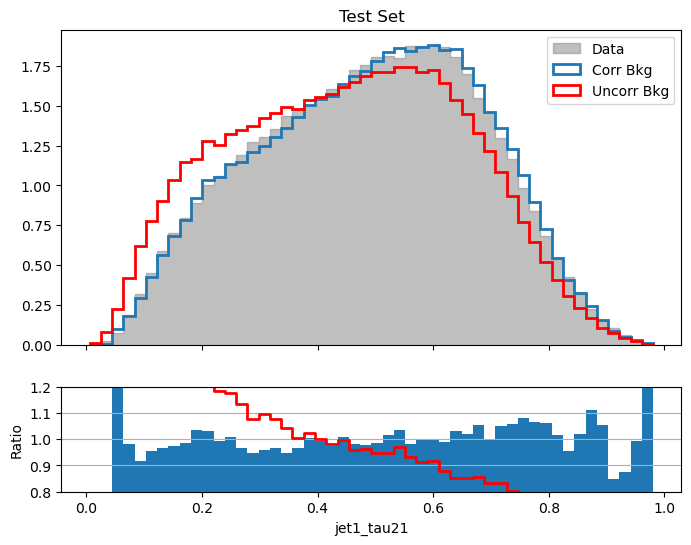

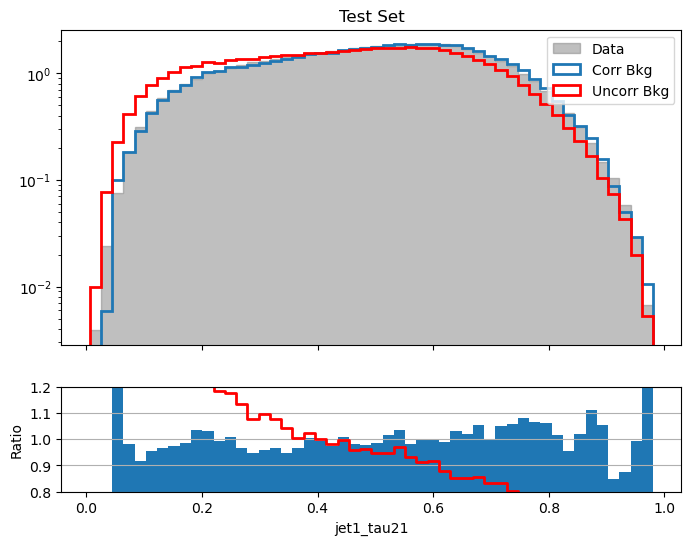

In [6]:
trainer.correctCurrent()
trainer.plotCurrent(50)

In [7]:
trainer.stepForward()

## variable 2

Training flow bkgFlow_step1_jet1_tau32


Loss: 0.9618527722358704, p = 181: 100%|██████████| 499/499 [01:29<00:00,  5.59it/s]


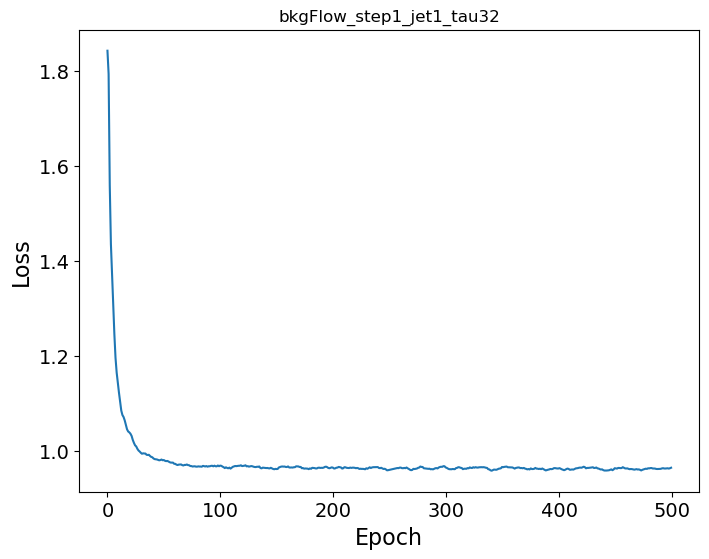

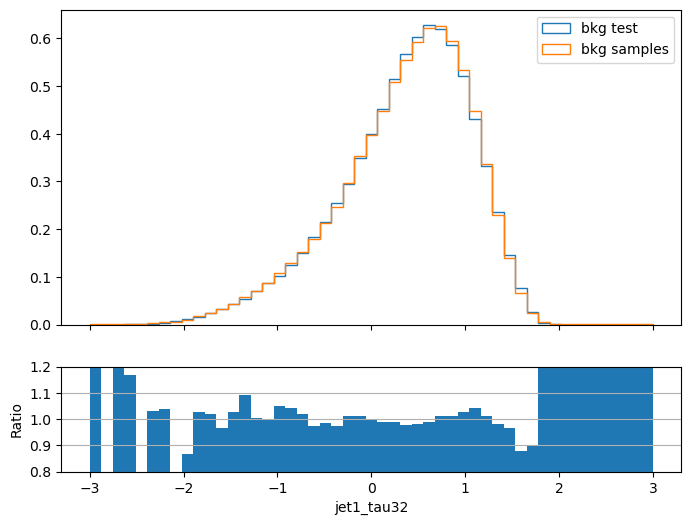

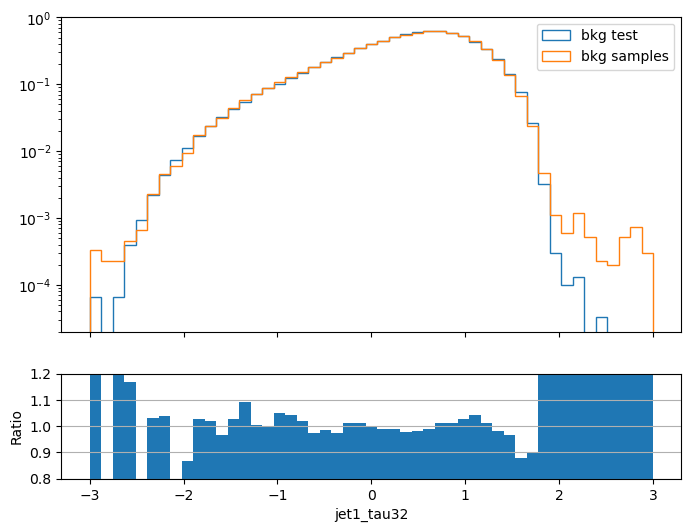

In [8]:
bs = 10000
n_epoch = 10
n_iter = n_epoch*b1_train.shape[0]//bs
trainer.trainCurrentBkg(patience=-1,n_epoch=n_iter,learning_rate=1e-3,bs=bs)
trainer.plotDensity(bkg=True)

Training flow dataFlow_step1_jet1_tau32


Loss: 0.8975688725709915, p = 222: 100%|██████████| 500/500 [01:33<00:00,  5.36it/s]


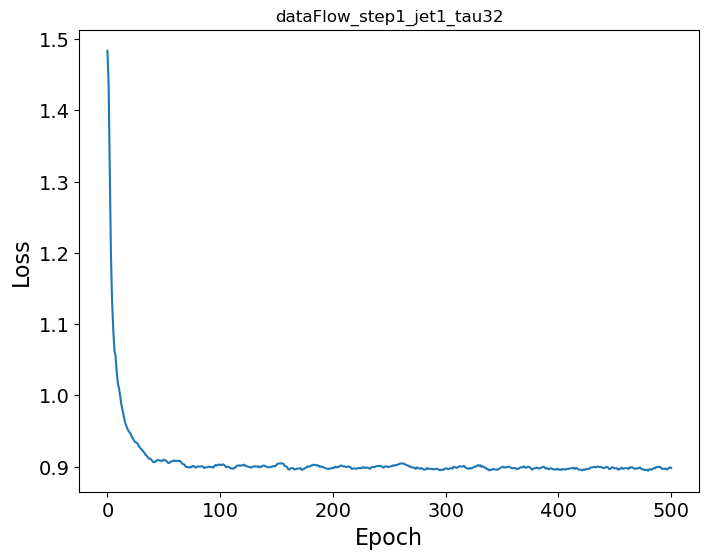

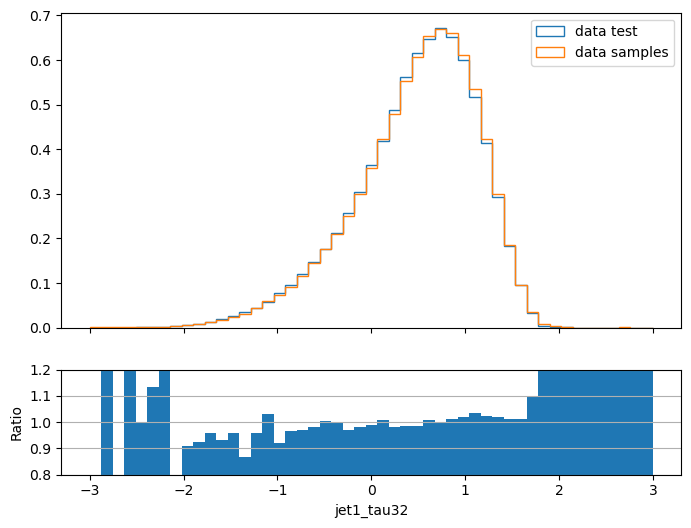

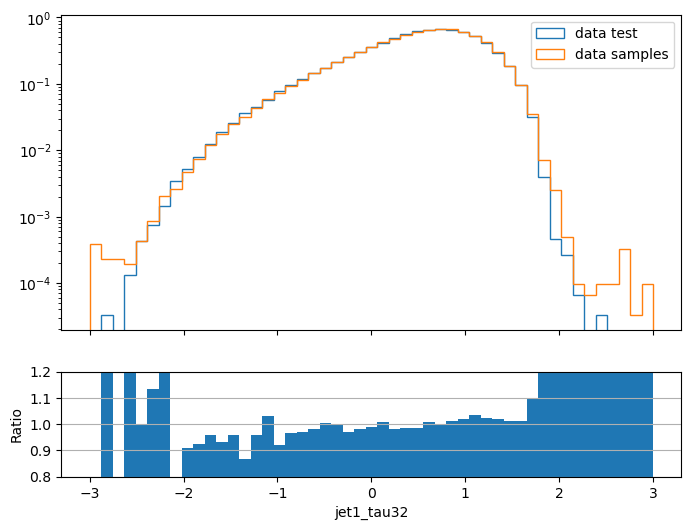

In [9]:
bs = 10000
n_epoch = 10
n_iter = n_epoch*rd_train.shape[0]//bs
trainer.trainCurrentData(patience=-1,n_epoch=n_iter,learning_rate=1e-3,bs=bs)
trainer.plotDensity(data=True)

100%|██████████| 25/25 [00:00<00:00, 29.17it/s]


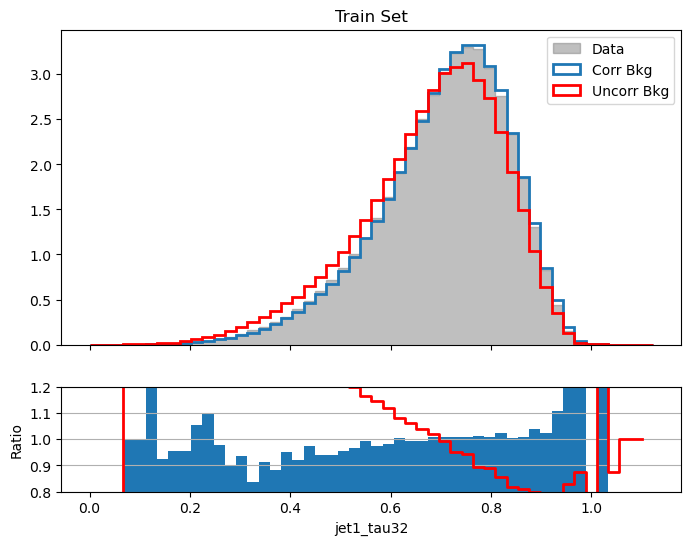

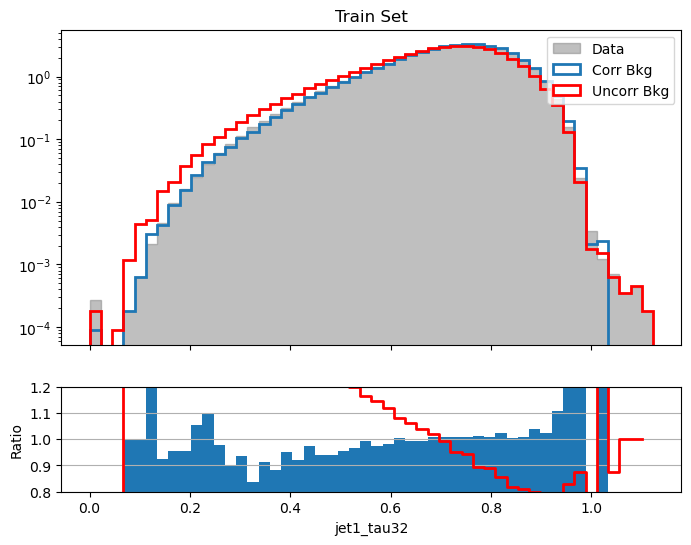

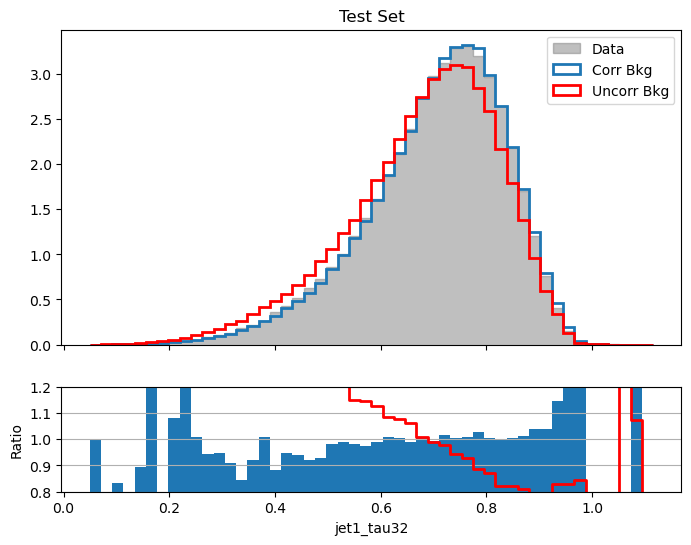

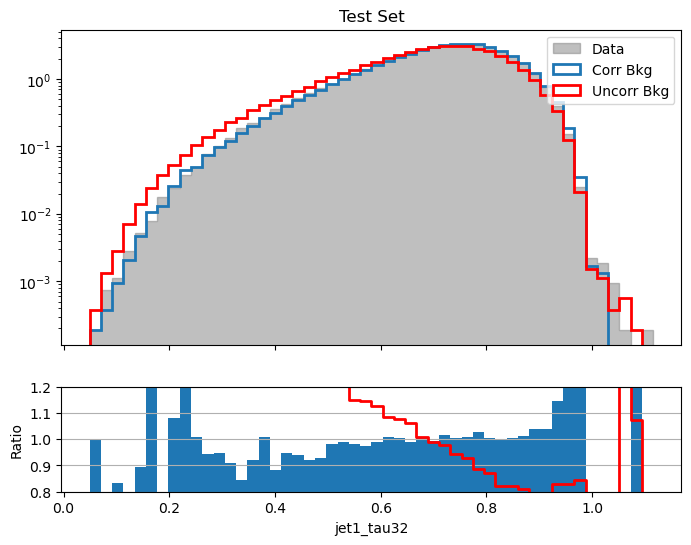

In [10]:
trainer.correctCurrent()
trainer.plotCurrent(50)

In [11]:
trainer.stepForward()

## variable 3

Training flow bkgFlow_step2_jet1_tau43


Loss: 0.46171177566051486, p = 176: 100%|██████████| 499/499 [01:27<00:00,  5.71it/s]


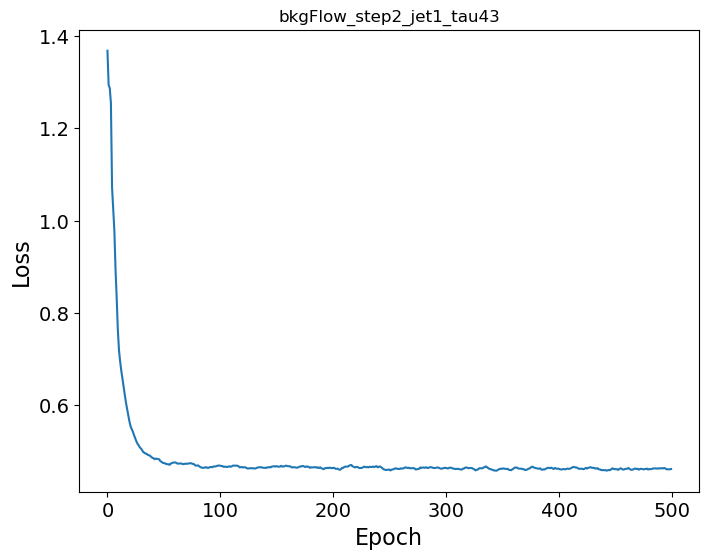

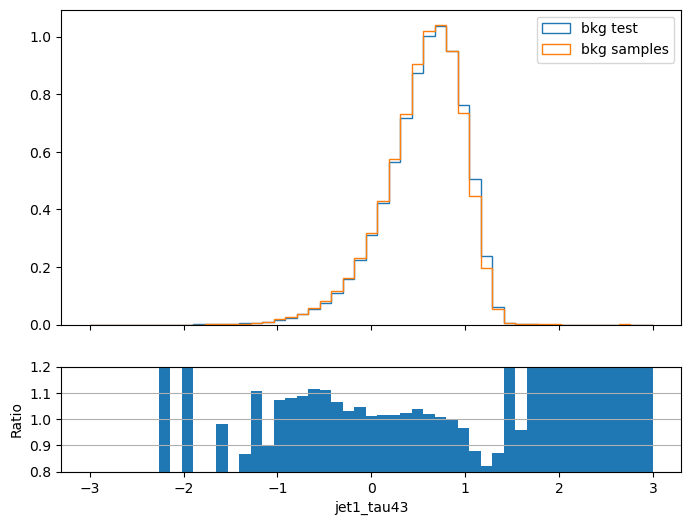

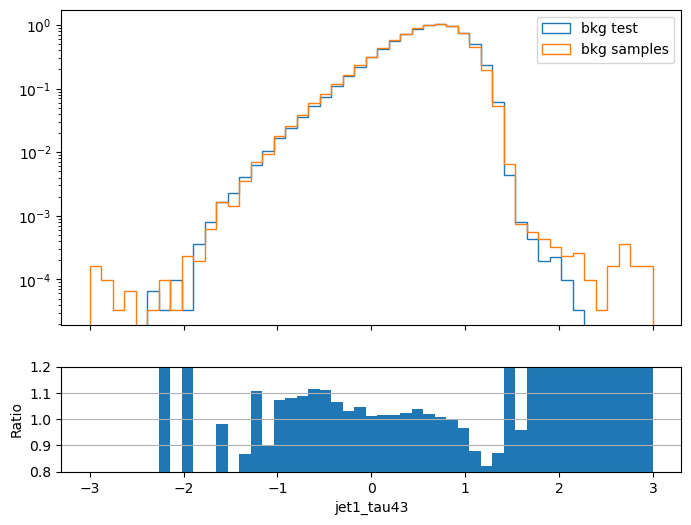

In [12]:
bs = 10000
n_epoch = 10
n_iter = n_epoch*b1_train.shape[0]//bs
trainer.trainCurrentBkg(patience=-1,n_epoch=n_iter,learning_rate=1e-3,bs=bs)
trainer.plotDensity(bkg=True)

Training flow dataFlow_step2_jet1_tau43


Loss: 0.39650504648685453, p = 152: 100%|██████████| 500/500 [01:27<00:00,  5.71it/s]


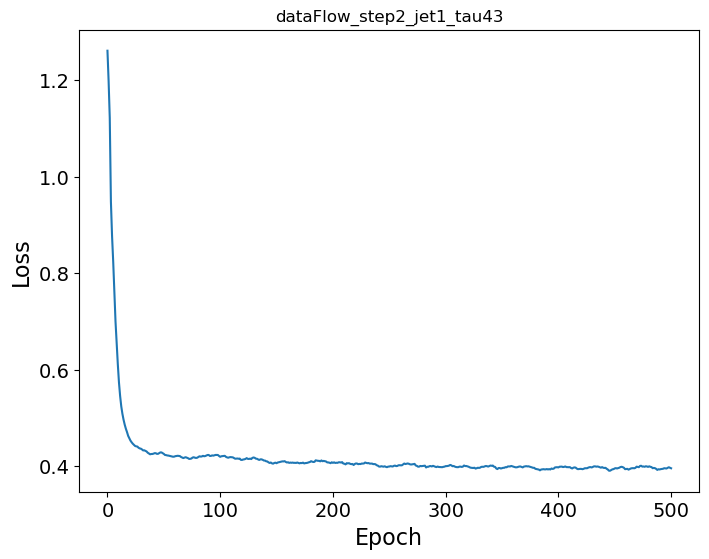

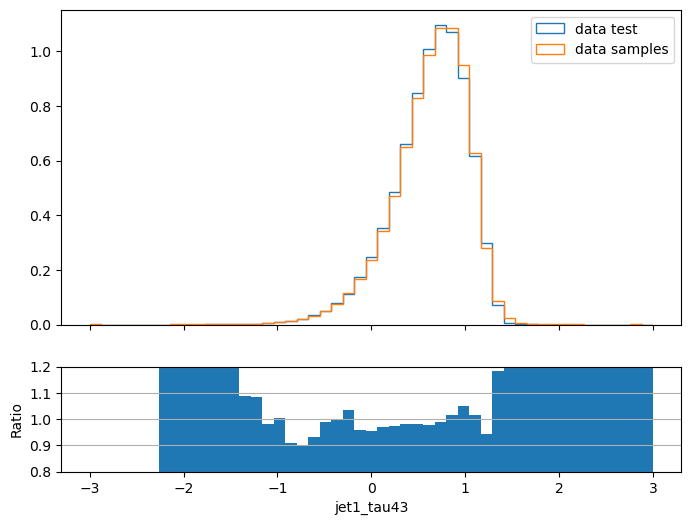

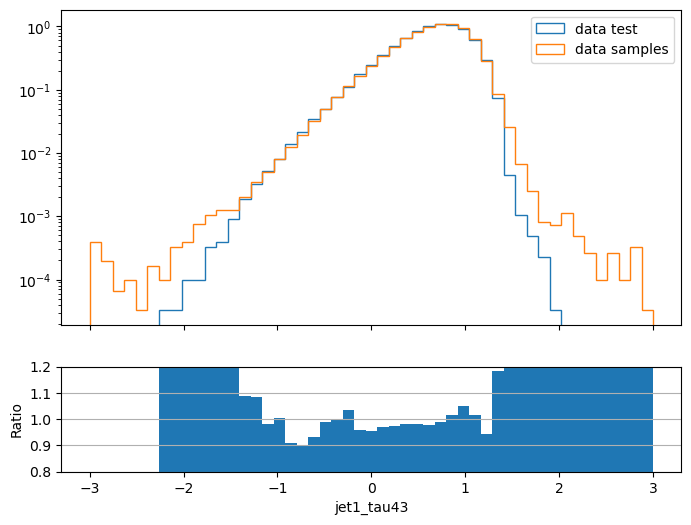

In [13]:
bs = 10000
n_epoch = 10
n_iter = n_epoch*rd_train.shape[0]//bs
trainer.trainCurrentData(patience=-1,n_epoch=n_iter,learning_rate=1e-3,bs=bs)
trainer.plotDensity(data=True)

100%|██████████| 25/25 [00:00<00:00, 33.04it/s]


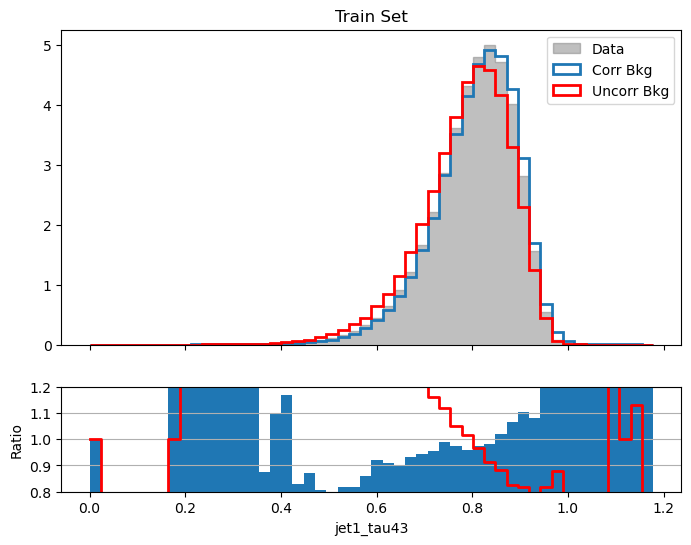

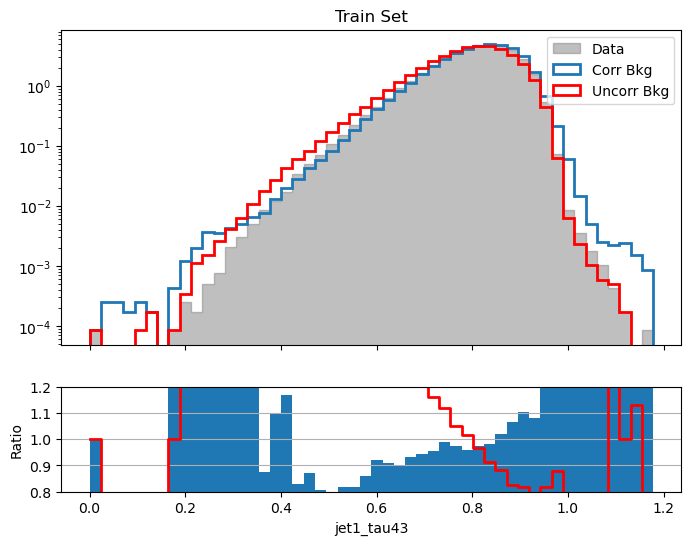

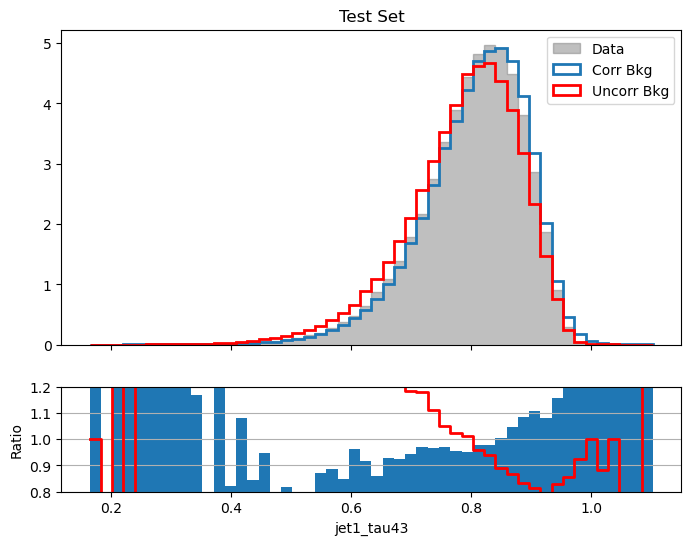

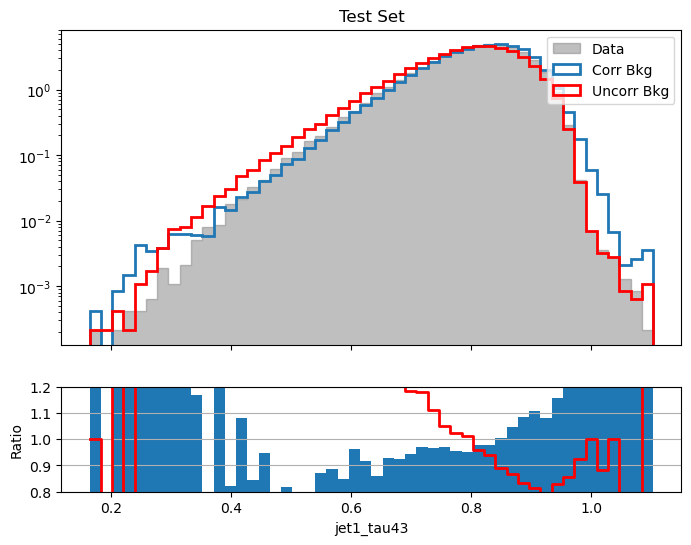

In [14]:
trainer.correctCurrent()
trainer.plotCurrent(50)